In [1]:
# Load library imports
import sys
import torch
import random
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from scipy.stats import skew
import matplotlib.pyplot as plt
from shapely.geometry import box
from shapely.geometry import Point


# Load project Imports
from src.utils.config_loader import load_project_config
from src.graph_building.graph_construction import build_mesh, \
    define_catchment_polygon
from src.visualisation.mapped_visualisations import plot_interactive_mesh, \
    plot_interactive_mesh_colour_coded, plot_directional_mesh
from src.data_ingestion.static_data_ingestion import load_land_cover_data, \
    load_process_elevation_data, derive_slope_data
from src.graph_building.data_merging import reorder_static_columns

In [2]:
# Set up logger config
logging.basicConfig(
    level=logging.INFO,
   format='%(levelname)s - %(message)s',
#    format='%(asctime)s - %(levelname)s - %(name)s - %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)

# Set up logger for file and load config file for paths and params
logger = logging.getLogger(__name__)
config = load_project_config(config_path="config/project_config.yaml")
notebook = True

# Set up seeding to define global states
random_seed = config["global"]["pipeline_settings"]["random_seed"]
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define notebook demo catchment
catchments_to_process = config["global"]["pipeline_settings"]["catchments_to_process"]
catchment = catchments_to_process[0]
run_defra_API_calls = config["global"]["pipeline_settings"]["run_defra_api"]

logger.info(f"Show Notebook Outputs: {notebook}")
logger.info(f"Notebook Demo Catchment: {catchment.capitalize()}")

INFO - Loading configuration from: /Users/charlotte/Desktop/Dissertation_Code/config/project_config.yaml
INFO - Show Notebook Outputs: True
INFO - Notebook Demo Catchment: Eden


Note: CAMELS-GB is a rich data resource at the correct resolution but the time series data ends in 2015 so is insufficient for this model. Some of the static features in the dataset are still applicable:

- Land cover (e.g., % Urban, % Arable, etc.)
- Elevation and slope (from DEMs in the CAMELS dataset)
- Soil type / BFIHOST
- Hydrogeological classifications (e.g., aquifer classes)
- Geographic coordinates (for snapping)

### Build mesh ###

To align ingested data with

In [3]:
# Select Catchment area from country wide gdf
define_catchment_polygon(
    england_catchment_gdf_path=config[catchment]['paths']['gis_catchment_boundary'],
    target_mncat=config[catchment]['target_mncat'],
    catchment=catchment,
    polygon_output_path=config[catchment]['paths']['gis_catchment_dir']
)

INFO - Eden and Esk boundary polygon(s) extracted from England data.
data/01_raw/eden/gis/eden_catchment_boundary/eden_combined_boundary.geojson
INFO - Combined Eden and Esk boundary saved to: data/01_raw/eden/gis/eden_catchment_boundary/eden_combined_boundary.geojson


In [4]:
# NB: mesh_nodes_gdf are the centroid coords, mesh_cells_gdf_polygons are polygons for e.g. averaging area
mesh_nodes_table, mesh_nodes_gdf, mesh_cells_gdf_polygons, catchment_polygon = build_mesh(
    shape_filepath=config[catchment]['paths']['gis_catchment_dir'],
    output_path=config[catchment]['paths']['mesh_nodes_output'],
    catchment=catchment,
    grid_resolution=config[catchment]['preprocessing']['graph_construction']['grid_resolution']
)

INFO - BUILD_MESH: Starting mesh construction with input: data/01_raw/eden/gis/eden_catchment_boundary/eden_combined_boundary.geojson and resolution: 1000m

INFO - Finding eden catchment spatial boundaries...

INFO - Loading  boundary from: data/01_raw/eden/gis/eden_catchment_boundary/eden_combined_boundary.geojson
INFO - Single polygon found in the catchment boundary.
INFO - Catchment bounding box: min_x=325093.81960000005, min_y=495490.0, max_x=389010.0, max_y=590440.0

INFO - Aligned minx: 325000.0, miny: 495000.0, maxx: 390000.0, maxy: 591000.0
INFO - Number of x-coordinates (bottom-left): 66
INFO - Number of y-coordinates (bottom-left): 97

INFO - Generated 6402 grid cells (centroids and polygons) within bounding box (before filtering).
INFO - Filtered down to catchment boundary containing 2750 nodes

INFO - First few mesh nodes (centroids with coordinates):

     node_id   easting  northing       lon        lat
64         0  325500.0  559500.0 -3.163979  54.924606
130        1  3

### Land Cover Data Ingestion and Preprocessing ###

In [5]:
# UKCEH LCM2023
agg_land_cover_df = load_land_cover_data(
    tif_path=config[catchment]['paths']['raw_land_cover_path'],
    csv_path=config[catchment]['paths']['land_cover_csv_path'],
    catchment=catchment,
    shape_filepath=config[catchment]['paths']['gis_catchment_dir']
)

display(agg_land_cover_df)

INFO - Loading land cover data from data/01_raw/eden/static/land_cover/gb2023lcm1km_dominant_aggregate.tif...
INFO - Finding eden catchment spatial boundaries...

INFO - Loading  boundary from: data/01_raw/eden/gis/eden_catchment_boundary/eden_combined_boundary.geojson
INFO - Single polygon found in the catchment boundary.
INFO - Catchment bounding box: min_x=325093.81960000005, min_y=495490.0, max_x=389010.0, max_y=590440.0

INFO - Land cover data clipped to catchment bounding box.

INFO - Converting 'easting'/'northing' to 'lon'/'lat'...
INFO - Land Cover data succesfully saved to data/02_processed/eden/static/land_cover/land_cover.csv.


northing   easting land_cover_code       lon        lat
0     590500.0  325500.0               4 -3.172091  55.203115
1     590500.0  326500.0               1 -3.156383  55.203265
2     590500.0  327500.0               1 -3.140674  55.203413
3     590500.0  328500.0               4 -3.124966  55.203559
4     590500.0  329500.0               1 -3.109257  55.203703
...        ...       ...             ...       ...        ...
6235  495500.0  385500.0               4 -2.224607  54.354824
6236  495500.0  386500.0               4 -2.209220  54.354851
6237  495500.0  387500.0               5 -2.193834  54.354877
6238  495500.0  388500.0               5 -2.178448  54.354901
6239  495500.0  389500.0               5 -2.163062  54.354923

[6240 rows x 5 columns]

**UKCEH Aggregate Class (AC) -> Mapped Classes**  
    1. Broadleaf woodland -> 1. Woodland  
    2. Coniferous woodland -> 1. Woodland  
    3. Arable -> 2. Arable  
    4. Improved grassland -> 3. Improved grassland  
    5. Semi-natural grassland -> 4. Semi-natural grassland  
    6. Mountain, heath and bog -> 5. Mountain, heath and bog  
    7. Saltwater -> 6. Water & Coastal  
    8. Freshwater -> 6. Water & Coastal  
    9. Coastal -> 6. Water & Coastal  
    10. Built-up areas and gardens -> 7. Urban & Suburban  

In [6]:
logger.info(f"Preparing land cover data for visual check...")

# Convert land_cover_df to a GeoDataFrame and create a geometry column using the 'lon' and 'lat' coordinates
geometry_lc_for_plot = [Point(xy) for xy in zip(agg_land_cover_df['lon'], agg_land_cover_df['lat'])]
land_cover_gdf_for_plot = gpd.GeoDataFrame(agg_land_cover_df.copy(), geometry=geometry_lc_for_plot, crs="EPSG:4326")
    
land_cover_labels = {1: "Woodland", 2: "Arable", 3: "Improved grassland",
                     4: "Semi-Natural Grassland", 5: "Mountain, heath and bog",
                     6: "Water & Coastal", 7: "Urban and Suburban"}

land_cover_colors = {1: "#665142", 2: "#a2a182", 3: "#9CBD8B", 4: "#647D57",
                     5: "#b7b1aa", 6: "#4d85ba", 7: "#8e412e"}

# Plot bounding box of data to check spatial geometry (notebook only)
land_cover_map = plot_interactive_mesh_colour_coded(
    mesh_nodes_gdf=land_cover_gdf_for_plot,
    catchment_polygon=catchment_polygon,
    map_blue=config['global']['visualisations']['maps']['map_blue'],
    esri=config['global']['visualisations']['maps']['esri'],
    esri_attr=config['global']['visualisations']['maps']['esri_attr'],
    static_output_path=f"{config[catchment]['visualisations']['maps']['static_mesh_map_output']}_land_cover",
    interactive_output_path=f"{config[catchment]['visualisations']['maps']['interactive_mesh_map_output']}_land_cover",
    category_colors=land_cover_colors,
    category_labels=land_cover_labels,
    grid_resolution=config[catchment]['preprocessing']['graph_construction']['grid_resolution'],
    interactive=config['global']['visualisations']['maps']['display_interactive_map']
)

# Display map in notebook
land_cover_map

INFO - Preparing land cover data for visual check...
INFO - PLOT_INTERACTIVE_MESH: Plotting catchment mesh overlaid on map.
INFO - Interactive map file saved to: results/figures/eden/maps/interactive_mesh_map_land_cover_1000.html



Merge into nodes mesh

In [7]:
merged_gdf_nodes_landuse = mesh_nodes_gdf.merge(
    agg_land_cover_df[['easting', 'northing', 'land_cover_code']],
    on=['easting', 'northing'],
    how='left'  # left join to keep all centroids, even NaN
)

In [8]:
display(merged_gdf_nodes_landuse)

geometry  node_id   easting  northing       lon  \
0     POINT (325500.000 559500.000)        0  325500.0  559500.0 -3.163979   
1     POINT (326500.000 528500.000)        1  326500.0  528500.0 -3.140511   
2     POINT (326500.000 529500.000)        2  326500.0  529500.0 -3.140763   
3     POINT (326500.000 537500.000)        3  326500.0  537500.0 -3.142781   
4     POINT (326500.000 558500.000)        4  326500.0  558500.0 -3.148123   
...                             ...      ...       ...       ...       ...   
2745  POINT (387500.000 511500.000)     2745  387500.0  511500.0 -2.194515   
2746  POINT (387500.000 512500.000)     2746  387500.0  512500.0 -2.194558   
2747  POINT (387500.000 513500.000)     2747  387500.0  513500.0 -2.194600   
2748  POINT (387500.000 514500.000)     2748  387500.0  514500.0 -2.194643   
2749  POINT (388500.000 514500.000)     2749  388500.0  514500.0 -2.179193   

            lat land_cover_code  
0     54.924606               3  
1     54.646229               4  
2     54.655214               4  
3     54.727092               4  
4     54.915770               3  
...         ...             ...  
2745  54.498668               5  
2746  54.507655               5  
2747  54.516642               5  
2748  54.525629               5  
2749  54.525653               5  

[2750 rows x 7 columns]

In [9]:
merged_gdf_nodes_landuse['land_cover_code'].value_counts()

land_cover_code
3    1701
4     458
5     221
1     210
2      89
7      36
6      35
Name: count, dtype: int64

### Elevation Data Ingestion and Preprocessing ###

In [10]:
# DIGIMAPS (via OS Terrain 5 / Terrain 50)
elevation_gdf_polygon, clipped_dtm = load_process_elevation_data(
    dir_path=config[catchment]['paths']['elevation_dir_path'],
    csv_path=config[catchment]['paths']['elevation_tif_path'],
    catchment_gdf=catchment_polygon,
    mesh_cells_gdf_polygons=mesh_cells_gdf_polygons,
    catchment=catchment,
    elev_max=config[catchment]['preprocessing']['catchment_max_elevation'],
    elev_min=config[catchment]['preprocessing']['catchment_min_elevation'],
    output_geojson_dir=config[catchment]['paths']['output_polygon_dir'],
    grid_resolution=config[catchment]['preprocessing']['graph_construction']['grid_resolution']
)

INFO - Loading Elevation Data: Starting DTM processing from data/01_raw/eden/static/elevation/ directory...
INFO - Found 196 DTM .asc tiles.
INFO - Merged DTM saved to data/02_processed/eden/static/elevation/elevation.tif
INFO - DTM raster clipped to catchment bounding box.
INFO - Mean elevation calculated for each mesh node using zonal statistics.
INFO - Loading, merging and aggregating DTM elevation data complete for eden catchment.

INFO - No NaN 'mean_elevation' value found. Continuing with Processing.

INFO - Check eden catchment mean_elevation sits in known bounds: 8.0 - 945.4...
WARNING - WARNING: Capping 21 nodes below 8.00 and 0 nodes above 945.40.
INFO - Mesh cell polygons saved to: data/02_processed/eden/gis/eden_mesh_cells_polygons.geojson



In [11]:
elevation_gdf_polygon

polygon_geometry  \
original_poly_index                                                      
64                   POLYGON ((326000.000 559000.000, 326000.000 56...   
130                  POLYGON ((327000.000 528000.000, 327000.000 52...   
131                  POLYGON ((327000.000 529000.000, 327000.000 53...   
139                  POLYGON ((327000.000 537000.000, 327000.000 53...   
160                  POLYGON ((327000.000 558000.000, 327000.000 55...   
...                                                                ...   
6030                 POLYGON ((388000.000 511000.000, 388000.000 51...   
6031                 POLYGON ((388000.000 512000.000, 388000.000 51...   
6032                 POLYGON ((388000.000 513000.000, 388000.000 51...   
6033                 POLYGON ((388000.000 514000.000, 388000.000 51...   
6130                 POLYGON ((389000.000 514000.000, 389000.000 51...   

                     node_id  mean_elevation  
original_poly_index                           
64                         0        9.134474  
130                        1      788.937188  
131                        2      730.159766  
139                        3      288.669258  
160                        4        9.613750  
...                      ...             ...  
6030                    2745      498.761484  
6031                    2746      433.720234  
6032                    2747      443.355781  
6033                    2748      472.260000  
6130                    2749      462.023984  

[2750 rows x 3 columns]

Skewness: 0.981


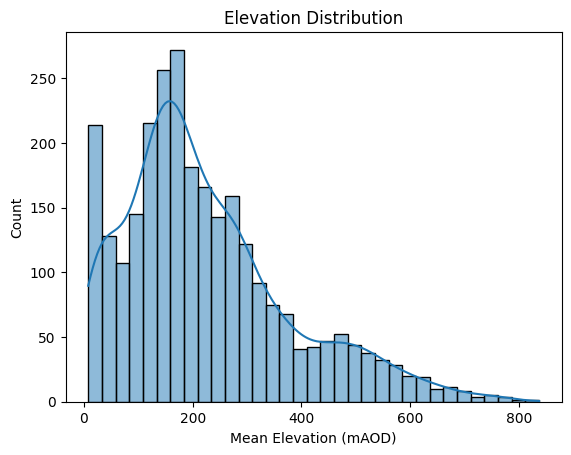

In [12]:
print(f"Skewness: {skew(mesh_cells_gdf_polygons['mean_elevation']):.3f}")

sns.histplot(mesh_cells_gdf_polygons['mean_elevation'], kde=True)
plt.title("Elevation Distribution")
plt.xlabel("Mean Elevation (mAOD)")
plt.show()


Moderate skew but not concerning enough at this point to require transformation especially as it wil be scaled. Will return to after first model iteration.

Merge into mesh

In [13]:
merged_gdf_nodes_elevation = merged_gdf_nodes_landuse.merge(
    elevation_gdf_polygon[['node_id', 'mean_elevation', 'polygon_geometry']],
    on='node_id',
    how='left'  # left join to keep all centroids, even NaN
)

In [14]:
display(merged_gdf_nodes_elevation)

geometry  node_id   easting  northing       lon  \
0     POINT (325500.000 559500.000)        0  325500.0  559500.0 -3.163979   
1     POINT (326500.000 528500.000)        1  326500.0  528500.0 -3.140511   
2     POINT (326500.000 529500.000)        2  326500.0  529500.0 -3.140763   
3     POINT (326500.000 537500.000)        3  326500.0  537500.0 -3.142781   
4     POINT (326500.000 558500.000)        4  326500.0  558500.0 -3.148123   
...                             ...      ...       ...       ...       ...   
2745  POINT (387500.000 511500.000)     2745  387500.0  511500.0 -2.194515   
2746  POINT (387500.000 512500.000)     2746  387500.0  512500.0 -2.194558   
2747  POINT (387500.000 513500.000)     2747  387500.0  513500.0 -2.194600   
2748  POINT (387500.000 514500.000)     2748  387500.0  514500.0 -2.194643   
2749  POINT (388500.000 514500.000)     2749  388500.0  514500.0 -2.179193   

            lat land_cover_code  mean_elevation  \
0     54.924606               3        9.134474   
1     54.646229               4      788.937188   
2     54.655214               4      730.159766   
3     54.727092               4      288.669258   
4     54.915770               3        9.613750   
...         ...             ...             ...   
2745  54.498668               5      498.761484   
2746  54.507655               5      433.720234   
2747  54.516642               5      443.355781   
2748  54.525629               5      472.260000   
2749  54.525653               5      462.023984   

                                       polygon_geometry  
0     POLYGON ((326000.000 559000.000, 326000.000 56...  
1     POLYGON ((327000.000 528000.000, 327000.000 52...  
2     POLYGON ((327000.000 529000.000, 327000.000 53...  
3     POLYGON ((327000.000 537000.000, 327000.000 53...  
4     POLYGON ((327000.000 558000.000, 327000.000 55...  
...                                                 ...  
2745  POLYGON ((388000.000 511000.000, 388000.000 51...  
2746  POLYGON ((388000.000 512000.000, 388000.000 51...  
2747  POLYGON ((388000.000 513000.000, 388000.000 51...  
2748  POLYGON ((388000.000 514000.000, 388000.000 51...  
2749  POLYGON ((389000.000 514000.000, 389000.000 51...  

[2750 rows x 9 columns]

### Derive slope data from DEM ###

In [15]:
# Derived from higher resolution DEM data in previous step
slope_gdf, directional_edge_weights = derive_slope_data(
    high_res_raster=clipped_dtm,
    mesh_cells_gdf_polygons=mesh_cells_gdf_polygons,
    catchment=catchment,
    direction_output_path=config[catchment]['paths']['direction_edge_weights_path'],
    slope_output_path=config[catchment]['paths']['slope_path']
)

INFO - Deriving slope magnitude and direction data for eden catchment...

<class 'xarray.core.dataarray.DataArray'>
<xarray.DataArray (y: 1900, x: 1280)> Size: 10MB
array([[220.6, 214.9, 209.3, ..., 173.1, 172.8, 171.7],
       [225.7, 225.4, 221.9, ..., 179.2, 179.4, 179. ],
       [243. , 237.5, 234.4, ..., 184.7, 184.1, 183.4],
       ...,
       [573. , 566.3, 574.5, ..., 625.3, 621.5, 619.2],
       [564.9, 558.3, 568.1, ..., 627. , 622.2, 619.2],
       [554.3, 547.8, 550.2, ..., 628.4, 625.8, 621.4]],
      shape=(1900, 1280), dtype=float32)
Coordinates:
  * x            (x) float64 10kB 3.251e+05 3.251e+05 ... 3.89e+05 3.89e+05
  * y            (y) float64 15kB 5.904e+05 5.904e+05 ... 4.955e+05 4.955e+05
    band         int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     nan
INFO - Slope magnitude derived in degrees from DEM.
INFO - Slope aspect derived (0–360°) from DEM.

INFO - Aspect

/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


INFO - Directional slope (dx, dy) aggregated to 1km mesh for eden.
INFO - Converting 'easting'/'northing' to 'lon'/'lat'...
INFO - Slope and aspect derivation and preprocessing complete for eden catchment.

INFO - Direction Weights csv saved to data/02_processed/eden/static/slope/direction_edge_weights.csv.
INFO - Slope magnitue and aspect csv saved to data/02_processed/eden/static/slope/slope_magnitude_aspect.csv.


Slope (Degrees): 2.161


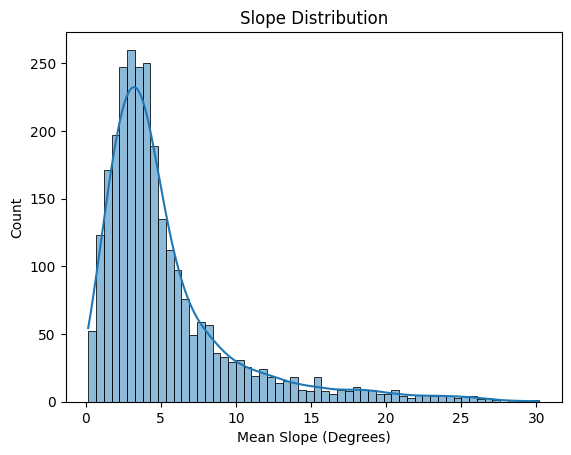

In [16]:
print(f"Slope (Degrees): {skew(slope_gdf['mean_slope_degrees']):.3f}")

sns.histplot(slope_gdf['mean_slope_degrees'], kde=True)
plt.title("Slope Distribution")
plt.xlabel("Mean Slope (Degrees)")
plt.show()


Slope Aspect (Sine): 0.062


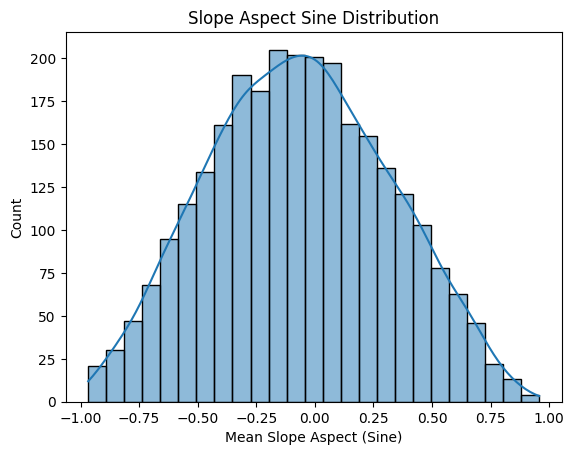

In [17]:
print(f"Slope Aspect (Sine): {skew(slope_gdf['mean_aspect_sin']):.3f}")

sns.histplot(slope_gdf['mean_aspect_sin'], kde=True)
plt.title("Slope Aspect Sine Distribution")
plt.xlabel("Mean Slope Aspect (Sine)")
plt.show()

Slope Aspect (Cosine): -0.149


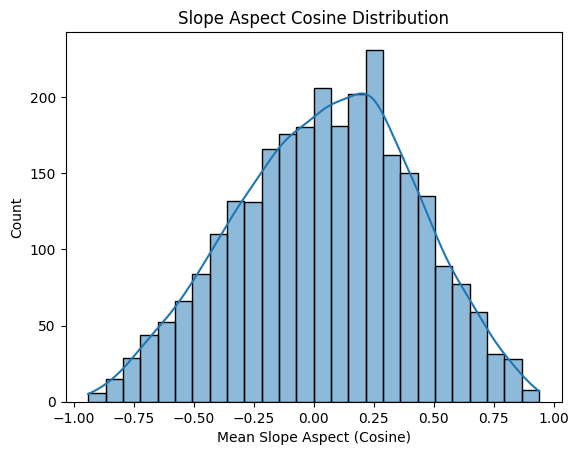

In [18]:
print(f"Slope Aspect (Cosine): {skew(slope_gdf['mean_aspect_cos']):.3f}")

sns.histplot(slope_gdf['mean_aspect_cos'], kde=True)
plt.title("Slope Aspect Cosine Distribution")
plt.xlabel("Mean Slope Aspect (Cosine)")
plt.show()

In [19]:
display(slope_gdf)

geometry  \
original_poly_index                                                      
64                   POLYGON ((326000.000 559000.000, 326000.000 56...   
130                  POLYGON ((327000.000 528000.000, 327000.000 52...   
131                  POLYGON ((327000.000 529000.000, 327000.000 53...   
139                  POLYGON ((327000.000 537000.000, 327000.000 53...   
160                  POLYGON ((327000.000 558000.000, 327000.000 55...   
...                                                                ...   
6030                 POLYGON ((388000.000 511000.000, 388000.000 51...   
6031                 POLYGON ((388000.000 512000.000, 388000.000 51...   
6032                 POLYGON ((388000.000 513000.000, 388000.000 51...   
6033                 POLYGON ((388000.000 514000.000, 388000.000 51...   
6130                 POLYGON ((389000.000 514000.000, 389000.000 51...   

                     node_id  mean_elevation  mean_slope_degrees  \
original_poly_index                                                
64                         0        9.134474            0.284105   
130                        1      788.937188           17.280076   
131                        2      730.159766           19.270125   
139                        3      288.669258            4.137629   
160                        4        9.613750            0.168347   
...                      ...             ...                 ...   
6030                    2745      498.761484            4.248611   
6031                    2746      433.720234            6.727472   
6032                    2747      443.355781            5.098769   
6033                    2748      472.260000            5.240568   
6130                    2749      462.023984            1.963654   

                     mean_aspect_sin  mean_aspect_cos  
original_poly_index                                    
64                         -0.052926         0.290490  
130                         0.524622         0.102005  
131                         0.664783         0.156837  
139                         0.200593         0.024045  
160                         0.410571         0.032501  
...                              ...              ...  
6030                        0.320453         0.099422  
6031                       -0.188337         0.425158  
6032                       -0.694729         0.036458  
6033                        0.352581        -0.216531  
6130                       -0.138327         0.341962  

[2750 rows x 6 columns]

In [20]:
merged_gdf_nodes_slope = merged_gdf_nodes_elevation.merge(
    slope_gdf[['node_id', 'mean_slope_degrees', 'mean_aspect_sin', 'mean_aspect_cos']],
    on='node_id',
    how='left'  # left join to keep all centroids, even NaN
)

merged_gdf_nodes_slope = reorder_static_columns(merged_gdf_nodes_slope)

In [21]:
display(merged_gdf_nodes_slope)

node_id                       geometry  \
0           0  POINT (325500.000 559500.000)   
1           1  POINT (326500.000 528500.000)   
2           2  POINT (326500.000 529500.000)   
3           3  POINT (326500.000 537500.000)   
4           4  POINT (326500.000 558500.000)   
...       ...                            ...   
2745     2745  POINT (387500.000 511500.000)   
2746     2746  POINT (387500.000 512500.000)   
2747     2747  POINT (387500.000 513500.000)   
2748     2748  POINT (387500.000 514500.000)   
2749     2749  POINT (388500.000 514500.000)   

                                       polygon_geometry   easting  northing  \
0     POLYGON ((326000.000 559000.000, 326000.000 56...  325500.0  559500.0   
1     POLYGON ((327000.000 528000.000, 327000.000 52...  326500.0  528500.0   
2     POLYGON ((327000.000 529000.000, 327000.000 53...  326500.0  529500.0   
3     POLYGON ((327000.000 537000.000, 327000.000 53...  326500.0  537500.0   
4     POLYGON ((327000.000 558000.000, 327000.000 55...  326500.0  558500.0   
...                                                 ...       ...       ...   
2745  POLYGON ((388000.000 511000.000, 388000.000 51...  387500.0  511500.0   
2746  POLYGON ((388000.000 512000.000, 388000.000 51...  387500.0  512500.0   
2747  POLYGON ((388000.000 513000.000, 388000.000 51...  387500.0  513500.0   
2748  POLYGON ((388000.000 514000.000, 388000.000 51...  387500.0  514500.0   
2749  POLYGON ((389000.000 514000.000, 389000.000 51...  388500.0  514500.0   

           lon        lat land_cover_code  mean_elevation  mean_slope_degrees  \
0    -3.163979  54.924606               3        9.134474            0.284105   
1    -3.140511  54.646229               4      788.937188           17.280076   
2    -3.140763  54.655214               4      730.159766           19.270125   
3    -3.142781  54.727092               4      288.669258            4.137629   
4    -3.148123  54.915770               3        9.613750            0.168347   
...        ...        ...             ...             ...                 ...   
2745 -2.194515  54.498668               5      498.761484            4.248611   
2746 -2.194558  54.507655               5      433.720234            6.727472   
2747 -2.194600  54.516642               5      443.355781            5.098769   
2748 -2.194643  54.525629               5      472.260000            5.240568   
2749 -2.179193  54.525653               5      462.023984            1.963654   

      mean_aspect_sin  mean_aspect_cos  
0           -0.052926         0.290490  
1            0.524622         0.102005  
2            0.664783         0.156837  
3            0.200593         0.024045  
4            0.410571         0.032501  
...               ...              ...  
2745         0.320453         0.099422  
2746        -0.188337         0.425158  
2747        -0.694729         0.036458  
2748         0.352581        -0.216531  
2749        -0.138327         0.341962  

[2750 rows x 12 columns]

### Checking the directional weights are logical and plausible based on the map: ###

In [22]:
directional_map = plot_directional_mesh(
    directional_edge_weights_gdf=directional_edge_weights,
    catchment_polygon=catchment_polygon,
    output_path=config[catchment]['visualisations']['maps']['interactive_directional_map_output'],
    esri=config['global']['visualisations']['maps']['esri'],
    esri_attr=config['global']['visualisations']['maps']['esri_attr']
)

logger.info(f"Pipeline step 'Interactive Directional Mesh Mapping' complete for {catchment} catchment.")

# # Show map in notebook
# directional_map

INFO - PLOT_DIRECTIONAL_MESH: Plotting catchment mesh with directional arrows.
INFO - Interactive directional map file saved to: results/figures/eden/maps/interactive_directional_map_1000.html

INFO - Pipeline step 'Interactive Directional Mesh Mapping' complete for eden catchment.


In [23]:
display(directional_edge_weights[['mean_slope_dx', 'mean_slope_dy', 'easting', 'northing']])

mean_slope_dx  mean_slope_dy   easting  northing
original_poly_index                                                  
64                       -0.000563       0.002758  325500.0  559500.0
130                       0.142167      -0.003685  326500.0  528500.0
131                       0.238534       0.055615  326500.0  529500.0
139                       0.012637       0.005224  326500.0  537500.0
160                       0.001861       0.000358  326500.0  558500.0
...                            ...            ...       ...       ...
6030                      0.027518       0.022048  387500.0  511500.0
6031                     -0.020881       0.040879  387500.0  512500.0
6032                     -0.065551      -0.003990  387500.0  513500.0
6033                      0.031937      -0.044977  387500.0  514500.0
6130                     -0.004269       0.010279  388500.0  514500.0

[2750 rows x 4 columns]

### Soil Type Data Ingestion ###

In [24]:
# CEH's Grid-to-Grid soil maps / HOST soil classes

### Aquifer Type Data Ingestion ###

In [25]:
# DEFRA / British Geological Survey (BGS)

### Aquifer Transmissivity Data Ingestion ###

In [26]:
# DEFRA / British Geological Survey (BGS)

### Geological Maps Data Ingestion ###

In [27]:
# DIGIMAPS (BGS data via Geology Digimap)

### Distance from River (Derived) ###

In [28]:
# Derived from DEFRA / DIGIMAP